**1. Read and import data**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
dataset = pd.read_csv('./data/salary.csv', sep='|')

In [3]:
dataset.head(2)

,id,job_title,location,salary_currency,career_level,experience_level,education_level,employment_type,job_function,job_benefits,company_process_time,company_size,company_industry,job_description,salary
0,1,Facility Maintenance & Smart Warehouse Manager,Bandung,IDR,Manajer/Asisten Manajer,5 tahun,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",Penuh Waktu,"Manufaktur,Pemeliharaan",NaN,NaN,NaN,NaN,Deskripsi PekerjaanRequirements :D3/SI from re...,NaN
1,2,Procurement Department Head,Jakarta Raya,IDR,Manajer/Asisten Manajer,5 tahun,"Sarjana (S1), Diploma Pascasarjana, Gelar Prof...",Penuh Waktu,"Manufaktur,Pembelian/Manajemen Material",NaN,25 days,51 - 200 pekerja,Manajemen/Konsulting HR,Job Role: 1. Responsible for material availabi...,NaN


**2. Cleaning the data**

In [4]:
# Size grafik
sns.set(rc={'figure.figsize':(10, 5)})

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34746 entries, 0 to 34745
Data columns (total 15 columns):
id                      34746 non-null int64
job_title               34746 non-null object
location                34746 non-null object
salary_currency         34742 non-null object
career_level            34746 non-null object
experience_level        30205 non-null object
education_level         34746 non-null object
employment_type         33402 non-null object
job_function            34746 non-null object
job_benefits            27330 non-null object
company_process_time    24555 non-null object
company_size            29103 non-null object
company_industry        33132 non-null object
job_description         34745 non-null object
salary                  9352 non-null float64
dtypes: float64(1), int64(1), object(13)
memory usage: 4.0+ MB


In [6]:
# Check null values
dataset.isnull().sum()

id                          0
job_title                   0
location                    0
salary_currency             4
career_level                0
experience_level         4541
education_level             0
employment_type          1344
job_function                0
job_benefits             7416
company_process_time    10191
company_size             5643
company_industry         1614
job_description             1
salary                  25394
dtype: int64

In [7]:
# Remove Column 
dataset = dataset.drop(labels=["id", "salary_currency", "job_benefits", "job_function", "job_description",
"company_process_time", "company_size", "company_industry", "employment_type"], axis=1)

Cleaning Salary

In [8]:
# Mengisi data salary yang nan atau null dengan median
dataset['salary'].fillna(dataset.groupby(["experience_level"])['salary'].transform('median'), inplace=True)
dataset['salary'] = dataset['salary'].round(0)

Cleaning Experience Level

In [9]:
# Convert experience_level str => float
dataset["experience_level"] = dataset["experience_level"].str.replace("\D", "").fillna(0).astype('float')

# Mengisi data experience_level yang 0 dengan median
dataset['experience_level'].replace(to_replace=0, value=dataset.groupby(["job_title"])['experience_level'].transform('median'), inplace=True)

Grouping Education Level

In [10]:
# edu = []
# for i in dataset['education_level']:
#     if i == "Diploma Pascasarjana, Gelar Professional, Magister (S2)":
#         edu.append('S1 - S2')
                                                                                 
#     else:
#         edu.append('Tidak terspesifikasi')
# dataset['education_level'] = edu

Outlier

In [11]:
dataset.dropna(inplace=True)

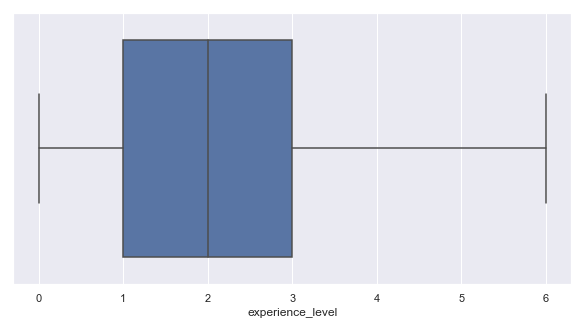

In [12]:
# Experience
per25Exp = dataset['experience_level'].quantile(0.25)
per75Exp = dataset['experience_level'].quantile(0.75)
iqrExp = per75Exp - per25Exp

lower_limit = per25Exp - 1.5 * iqrExp
upper_limit = per75Exp + 1.5 * iqrExp

dataset = dataset[~((dataset["experience_level"] < (lower_limit)) | (dataset["experience_level"] > (upper_limit)))]

sns.boxplot(dataset["experience_level"])
plt.show()

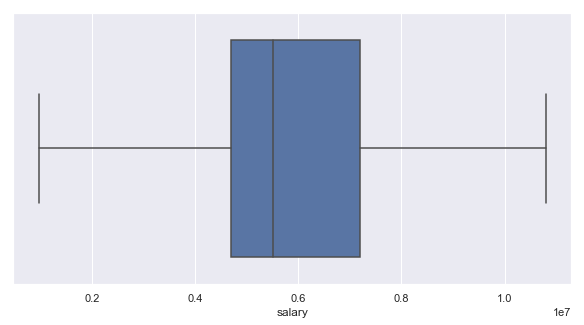

In [13]:
# Salary
per25Salary = dataset['salary'].quantile(0.25)
per75Salary = dataset['salary'].quantile(0.75)
iqrSalary = per75Salary - per25Salary

lower_limit = per25Salary - 1.5 * iqrSalary
upper_limit = per75Salary + 1.5 * iqrSalary

dataset = dataset[~((dataset["salary"] < (lower_limit)) | (dataset["salary"] > (upper_limit)))]

sns.boxplot(dataset["salary"])
plt.show()

Convert Type

In [14]:
dataset['career_level'] = dataset['career_level'].astype("category")
dataset['experience_level'] = dataset['experience_level'].astype("category")
dataset['education_level'] = dataset['education_level'].astype("category")

Result Cleaning

In [15]:
dataset.shape

(28607, 6)

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28607 entries, 0 to 34745
Data columns (total 6 columns):
job_title           28607 non-null object
location            28607 non-null object
career_level        28607 non-null category
experience_level    28607 non-null category
education_level     28607 non-null category
salary              28607 non-null float64
dtypes: category(3), float64(1), object(2)
memory usage: 979.1+ KB


In [17]:
# Check null values
dataset.isnull().sum()

job_title           0
location            0
career_level        0
experience_level    0
education_level     0
salary              0
dtype: int64

In [18]:
dataset.describe()

,salary
count,2.860700e+04
mean,5.980619e+06
std,1.923043e+06
min,9.600000e+05
25%,4.700000e+06
50%,5.500000e+06
75%,7.200000e+06
max,1.080000e+07


**3. Predict the salary**

In [19]:
X = pd.DataFrame(dataset, columns=["career_level", "experience_level", "education_level"])
Y = pd.DataFrame(dataset, columns=["salary"])

Metode OLS

In [20]:
modelOLS = smf.ols("salary~career_level + experience_level + education_level", data=dataset).fit()
print(modelOLS.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     2492.
Date:                Thu, 08 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:51:04   Log-Likelihood:            -4.3546e+05
No. Observations:               28607   AIC:                         8.710e+05
Df Residuals:                   28574   BIC:                         8.713e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                                                                                                                        coef    std err          t      P>|t|      [0.025      0.9

In [21]:
yPredOLS = modelOLS.predict(X)
yPredOLS.head()

0    1.006794e+07
1    1.030638e+07
2    8.252212e+06
3    1.005093e+07
4    5.388400e+06
dtype: float64

In [22]:
mean_squared_error(Y, yPredOLS)

975474968189.943

Metode Robust Reggression

In [23]:
modelRLM = smf.rlm("salary~career_level + experience_level + education_level", data=dataset).fit()
print(modelRLM.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 salary   No. Observations:                28607
Model:                            RLM   Df Residuals:                    28574
Method:                          IRLS   Df Model:                           32
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 08 Jun 2023                                         
Time:                        16:51:08                                         
No. Iterations:                    50                                         
                                                                                                                                                        coef    std err          z      P>|z|      [0.025      0.9

In [24]:
yPredRLM = modelRLM.predict(X)
yPredRLM.head()

0    10500000.0
1    10500000.0
2     8450000.0
3    10500000.0
4     5500000.0
dtype: float64

In [25]:
mean_squared_error(Y, yPredRLM)

1060118739508.8807

Metode Random Forest

**4. Visualization Data**